# GSR/GPS Explorations-Notebook

Dieses Notebook baut auf der Pipeline auf und bietet:

- Explorative GSR-Analyse (Zeitreihen, Histogramme)
- SCR-Statistiken
- GPS-Visualisierung (Scatter/"Heatmap")
- Interaktive Filter mit `ipywidgets`

Stelle sicher, dass du vorher mindestens einmal die Pipeline aus dem anderen Notebook oder über `src.main` ausgeführt hast, damit in `results/csv` Daten liegen.

In [3]:
import sys
from pathlib import Path

project_root = Path('..').resolve()
sys.path.append(str(project_root))
project_root

WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer')

In [13]:
from IPython.display import display, HTML

HTML("""
<style>
.widget-label { 
    font-size: 14pt !important;
}
.widget-dropdown, 
.widget-text,
.widget-slider {
    font-size: 14pt !important;
    width: 400px !important;
}
.widget-slider .noUi-target {
    height: 12px !important;
}
.widget-slider .noUi-handle {
    width: 20px !important;
    height: 20px !important;
}
</style>
""")


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ipywidgets import interact, interactive, widgets, fixed
from IPython.display import display

## 1. Verfügbare Ergebnis-Dateien finden

Wir suchen alle zusammengeführten GSR+GPS-CSV-Dateien aus `results/csv`.

In [5]:
csv_dir = (project_root / 'results' / 'csv')
csv_files = sorted(csv_dir.glob('output_GSR_GPS_*.csv')) if csv_dir.exists() else []

csv_files

[WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/csv/output_GSR_GPS_Neckarhalde_run13_female_5031975_20251125_114222.csv'),
 WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/csv/output_GSR_GPS_Neckarhalde_run13_female_5031975_20251125_115608.csv'),
 WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/csv/output_GSR_GPS_Neckarhalde_run13_female_5031975_20251125_120647.csv'),
 WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/csv/output_GSR_GPS_Neckarhalde_run13_female_5031975_20251125_122340.csv'),
 WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/csv/output_GSR_GPS_SCRonly_Neckarhalde_run13_female_5031975_20251125_114222.csv'),
 WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/csv/output_GSR_GPS_SCRonly_Neckarhalde_run13_female_5031975_20251125_115608.csv'),
 WindowsPath('C:/Users/peter/Documents/peterspython/GSR_GPS_Shimmer/results/cs

## 2. Interaktive Auswahl der Ergebnisdatei

Wenn mehrere Läufe vorhanden sind, kannst du hier auswählen, welche Datei analysiert werden soll.

In [6]:
def load_data(csv_path: Path):
    df = pd.read_csv(csv_path)
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    return df

def select_and_load(index=0):
    if not csv_files:
        print('Keine CSV-Dateien gefunden. Bitte zuerst die Pipeline ausführen.')
        return None
    csv_path = csv_files[index]
    print('Nutze Datei:', csv_path)
    df = load_data(csv_path)
    display(df.head())
    return df

if csv_files:
    file_dropdown = widgets.Dropdown(
        options=[(p.name, i) for i, p in enumerate(csv_files)],
        description='Run:',
        value=0,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )
    display(file_dropdown)
else:
    file_dropdown = None
    print('⚠️ Keine CSV-Dateien gefunden.')

Dropdown(description='Run:', layout=Layout(width='400px'), options=(('output_GSR_GPS_Neckarhalde_run13_female_…

In [7]:
# Diese Zelle lädt die aktuell im Dropdown gewählte Datei in df
if file_dropdown is not None:
    df = select_and_load(file_dropdown.value)
else:
    df = None

Nutze Datei: C:\Users\peter\Documents\peterspython\GSR_GPS_Shimmer\results\csv\output_GSR_GPS_Neckarhalde_run13_female_5031975_20251125_114222.csv


,Timestamp,Conductance,SCL_local,Threshold,SCR_Peak,Trigger,SCR_Latency_s,SCL_Baseline,SCL_Global,latitude,longitude,runId,study,name,birthYear,gender
0,2025-11-06 16:17:34,2.657754,2.657754,2.732754,0,0,NaN,2.651060,2.664846,48.752581,9.286507,13,Neckarhalde,Peter,5031975,female
1,2025-11-06 16:17:35,2.620284,2.639019,2.714019,0,0,NaN,2.650871,2.663372,48.752581,9.286507,13,Neckarhalde,Peter,5031975,female
2,2025-11-06 16:17:36,2.597905,2.625314,2.700314,0,0,NaN,2.650738,2.661804,48.752581,9.286507,13,Neckarhalde,Peter,5031975,female
3,2025-11-06 16:17:37,2.582086,2.614507,2.689507,0,0,NaN,2.650665,2.660148,48.752581,9.286507,13,Neckarhalde,Peter,5031975,female
4,2025-11-06 16:17:38,2.573100,2.606226,2.681226,0,0,NaN,2.650655,2.658412,48.752581,9.286507,13,Neckarhalde,Peter,5031975,female


## 3. Explorative GSR-Analyse

Wir plotten das GSR-Signal über die Zeit, inklusive SCL-Kurven und markierten SCR-Peaks/Triggern.

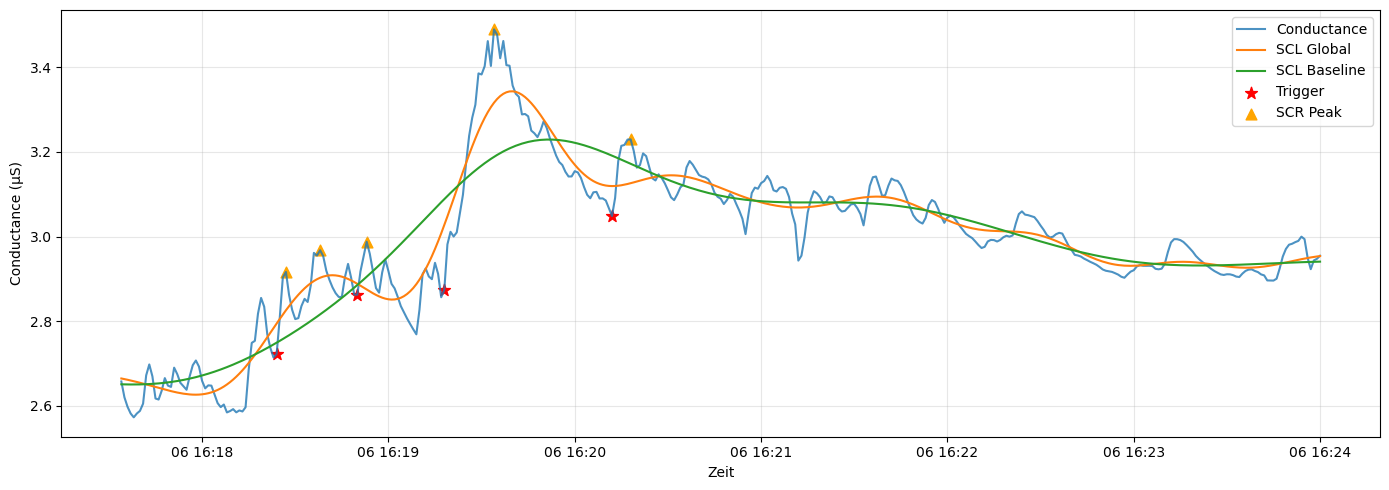

In [8]:
def plot_gsr(df, t_min=None, t_max=None):
    if df is None:
        print('Keine Daten geladen.')
        return

    d = df.copy()
    if t_min is not None:
        d = d[d['Timestamp'] >= t_min]
    if t_max is not None:
        d = d[d['Timestamp'] <= t_max]

    if d.empty:
        print('Zeitbereich leer.')
        return

    plt.figure(figsize=(14, 5))
    plt.plot(d['Timestamp'], d['Conductance'], label='Conductance', alpha=0.8)
    if 'SCL_Global' in d.columns:
        plt.plot(d['Timestamp'], d['SCL_Global'], label='SCL Global', linewidth=1.5)
    if 'SCL_Baseline' in d.columns:
        plt.plot(d['Timestamp'], d['SCL_Baseline'], label='SCL Baseline', linewidth=1.5)

    if 'Trigger' in d.columns:
        trigs = d[d['Trigger'] == 1]
        if not trigs.empty:
            plt.scatter(trigs['Timestamp'], trigs['Conductance'], color='red', marker='*', s=80, label='Trigger')

    if 'SCR_Peak' in d.columns:
        peaks = d[d['SCR_Peak'] == 1]
        if not peaks.empty:
            plt.scatter(peaks['Timestamp'], peaks['Conductance'], color='orange', marker='^', s=60, label='SCR Peak')

    plt.xlabel('Zeit')
    plt.ylabel('Conductance (µS)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

if df is not None:
    plot_gsr(df)

### Interaktive Auswahl eines Zeitfensters

Wir definieren einen einfachen Slider über den Indexbereich, um kleinere Ausschnitte zu betrachten.

In [9]:
if df is not None:
    n = len(df)
    if n > 0:
        def explore_window(start=0, window=300):
            end = min(start + window, len(df) - 1)
            sub = df.iloc[start:end].copy()
            plot_gsr(sub)

        start_slider = widgets.IntSlider(min=0, max=max(len(df)-1, 1), step=50, value=0, description='Start-Index')
        window_slider = widgets.IntSlider(min=60, max=2000, step=60, value=300, description='Fenstergröße')
        ui = widgets.VBox([start_slider, window_slider])
        out = widgets.interactive_output(explore_window, {'start': start_slider, 'window': window_slider})
        display(ui, out)
    else:
        print('DataFrame ist leer.')
else:
    print('Noch keine Daten geladen.')

Output()

## 4. SCR-Statistik

Histogramm der SCR-Latenzen und einfache Kennzahlen.

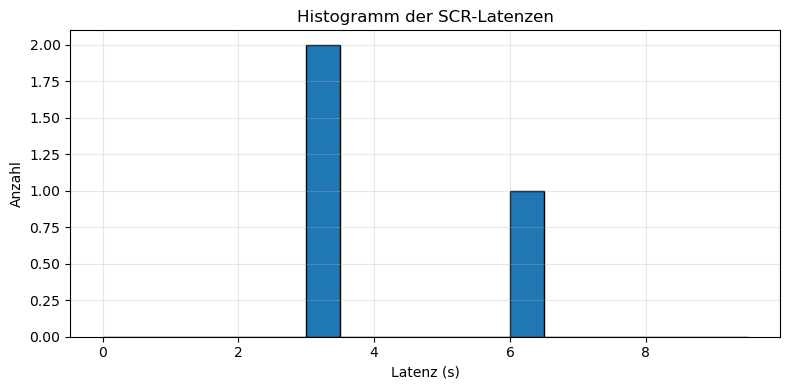

,Anzahl Peaks,Mittelwert (s),Median (s),Std (s)
0,4,7.0,4.5,6.164414


In [10]:
if df is not None and 'SCR_Latency_s' in df.columns:
    lat = df['SCR_Latency_s'].dropna()
    if not lat.empty:
        plt.figure(figsize=(8,4))
        plt.hist(lat, bins=np.arange(0, 10, 0.5), edgecolor='k')
        plt.xlabel('Latenz (s)')
        plt.ylabel('Anzahl')
        plt.title('Histogramm der SCR-Latenzen')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        display(pd.DataFrame({
            'Anzahl Peaks': [len(lat)],
            'Mittelwert (s)': [lat.mean()],
            'Median (s)': [lat.median()],
            'Std (s)': [lat.std()]
        }))
    else:
        print('Keine SCR-Latenzen vorhanden.')
else:
    print('Keine SCR_Latency_s-Spalte oder keine Daten.')

## 5. GPS-"Heatmap" / räumliche Verteilung

Wir nutzen eine einfache 2D-Hexbin-Darstellung auf Latitude/Longitude-Basis.


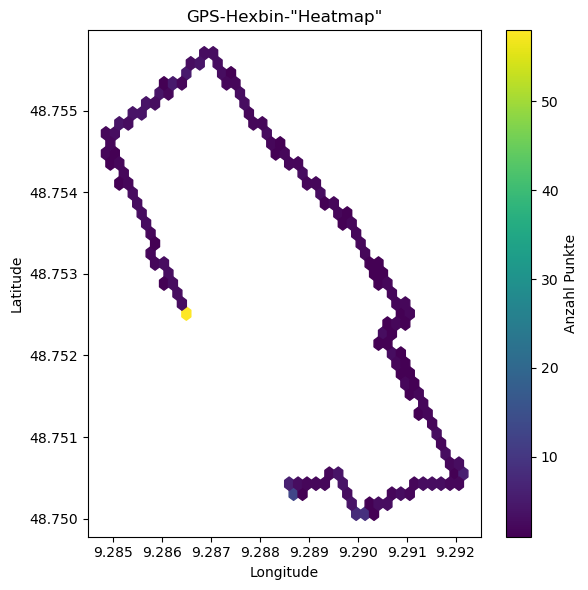

In [11]:
def plot_gps_hexbin(df, gridsize=40):
    if df is None:
        print('Keine Daten geladen.')
        return
    if not {'latitude', 'longitude'}.issubset(df.columns):
        print('Spalten latitude/longitude fehlen.')
        return
    d = df.dropna(subset=['latitude', 'longitude'])
    if d.empty:
        print('Keine GPS-Daten vorhanden.')
        return

    plt.figure(figsize=(6,6))
    hb = plt.hexbin(d['longitude'], d['latitude'], gridsize=gridsize, cmap='viridis', mincnt=1)
    cb = plt.colorbar(hb)
    cb.set_label('Anzahl Punkte')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GPS-Hexbin-"Heatmap"')
    plt.tight_layout()
    plt.show()

if df is not None:
    plot_gps_hexbin(df)
else:
    print('Noch keine Daten geladen.')

### Interaktives GPS-Filtering

Optional: Filter auf SCR-Peaks oder Triggerpunkte.

In [12]:
def plot_gps_points(df, mode='all'):
    if df is None:
        print('Keine Daten geladen.')
        return
    if not {'latitude', 'longitude'}.issubset(df.columns):
        print('Spalten latitude/longitude fehlen.')
        return

    if mode == 'all':
        d = df
        title = 'Alle GPS-Punkte'
    elif mode == 'peaks':
        d = df[df.get('SCR_Peak', 0) == 1]
        title = 'SCR-Peaks (GPS)'
    elif mode == 'triggers':
        d = df[df.get('Trigger', 0) == 1]
        title = 'Trigger (GPS)'
    else:
        d = df
        title = 'Alle GPS-Punkte'

    d = d.dropna(subset=['latitude', 'longitude'])
    if d.empty:
        print('Keine Daten für Modus', mode)
        return

    plt.figure(figsize=(6,6))
    plt.scatter(d['longitude'], d['latitude'], s=10, alpha=0.7)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.tight_layout()
    plt.show()

if df is not None:
    mode_dropdown = widgets.Dropdown(
        options=[('Alle', 'all'), ('Nur Peaks', 'peaks'), ('Nur Trigger', 'triggers')],
        value='all',
        description='Modus:',
        style={'description_width': 'initial'}
    )
    out = widgets.interactive_output(plot_gps_points, {'df': fixed(df), 'mode': mode_dropdown})
    display(mode_dropdown, out)
else:
    print('Noch keine Daten geladen.')

Dropdown(description='Modus:', options=(('Alle', 'all'), ('Nur Peaks', 'peaks'), ('Nur Trigger', 'triggers')),…

Output()